# Stochastic Simulation Assignment 1

Authors:

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Mandlebrot simulation

In [2]:
def Mandelbrot(c, max_iter, threshold = 2):
    '''Simulates the Mandlebrot set, given the maximum number of iterations, the threshold value of z, and the starting value of c.
    based on formula's found on https://en.wikipedia.org/wiki/Mandelbrot_set
    A number is part of the Mandlebrot set if the absolute value of z is smaller than threshold after a certain number of iterations are performed.
    The threshold is 2 by conventioon, but can be changed.'''
    z = c
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

        


In [3]:
def display_mandelbrot(xmin,xmax,ymin,ymax,width,height,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            imaginary_component = 1j
            n3[i,j] = Mandelbrot(r1[i] + imaginary_component*r2[j],max_iter, threshold)
    return (r1,r2,n3.T)

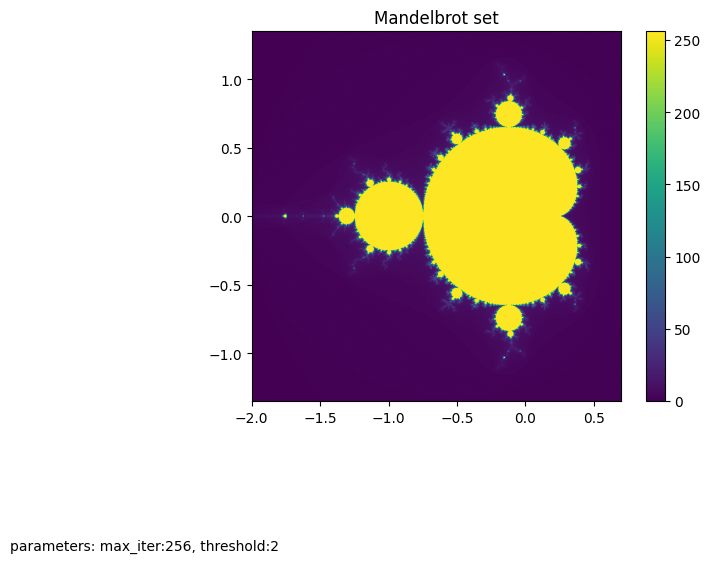

In [4]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
width, height = 1000, 1000

# parameters
max_iter = 256
threshold = 2

x,y,z = display_mandelbrot(xmin,xmax,ymin,ymax,width,height,max_iter, threshold = 2)

plt.imshow(z, extent=(xmin, xmax, ymin, ymax))
plt.title("Mandelbrot set")
plt.figtext(0,-0.2,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='center')
plt.colorbar()
plt.show()

In [5]:
# def Monte_carlo_mandelbrot(func, s, boundry)
#     points_in_mandelbrot = []
#     generated_points = np.random.uniform(0,1000, (s, 2))
#     for point in generated_points:
#         if func(point) >= boundry:
#             points_in_mandelbrot.append(func(point))
    
        
            



    
